# Demonstration of pyQuil simulation capabilities
### Ben Bartlett, 6.27.17

In [1]:
# Import everything
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
%matplotlib inline 

import pyquil.quil as pq    # Quil language
import pyquil.api as api    # Rigetti forest api
from pyquil.gates import *  # All QC logical gates

import time

In [2]:
def state0011(q1, q2):
    '''Prepare the state |00> + |11> on qubits q1 and q2'''
    return pq.Program(H(q1), CNOT(q1, q2))

In [3]:
def teleportQubit(alice, bob, ancilla):
    '''Perform quantum teleportation from sending to receiving qubits using a single ancilla'''
    # Set registers for Alice's qubit and Bob's ancilla and qubit
    aliceRegister = 0
    ancillaRegister = 1
    bobRegister = 2
    
    # Generate an EPR pair with Bob's receiving and ancillary qubits
    Hilbert = state0011(bob, ancilla)
    
    # Teleport Alice's qubit into Bob's ancilla 
    Hilbert.inst( CNOT(alice, ancilla),
                  H(alice) )
    
    # Measure Alice's qubit and Bob's ancilla and put them in a classical comms line
    Hilbert.measure(alice, aliceRegister)
    Hilbert.measure(ancilla, ancillaRegister)
    
    # Act on Bob's qubit with X and Z accordingly to reconstruct Alice's original state
    Hilbert.if_then(ancillaRegister, X(bob)) # If ancilla collapses to 1, apply X
    Hilbert.if_then(aliceRegister, Z(bob))   # If Alice's state collapses to 1, apply Z
    
    # Measure Bob's qubit
    Hilbert.measure(bob, bobRegister) 
    
    return Hilbert

In [4]:
def teleportationDemo(qvm): 
    '''Executes a few teleportations on the quantum VM qvm'''
    alice, bob, ancilla = 0, 2, 1
    # Teleport |0> 
    demo0 = pq.Program() 
    demo0 += teleportQubit(alice, bob, ancilla) 
    print "Teleporting |0> from Alice to Bob: ", qvm.run(demo0, [bob]) 
    
    # Teleport |1> 
    demo1 = pq.Program(X(alice)) # flip Alice's qubit from |0> to |1>
    demo1 += teleportQubit(alice, bob, ancilla) 
    print "Teleporting |1> from Alice to Bob: ", qvm.run(demo1, [bob]) 
    
    # Teleport 1/sqrt(2)*(|0> + |1>) 
    demo1 = pq.Program(H(alice)) # flip Alice's qubit from |0> to |+>
    demo1 += teleportQubit(alice, bob, ancilla) 
    print "Teleporting 1/sqrt(2)*(|0> + |1>) from Alice to Bob: ", qvm.run(demo1, [bob]) 
    
    print "\n"

In [5]:
def teleportationRotationDemo(qvm):
    '''Tests teleportation capabilities against expected values for range of phases'''
    # Perform teleportation across angles 
    alice, bob, ancilla = 0, 2, 1
    angles = np.linspace(0, 2* np.pi, 20) # Series of angles to be applied to rotation-X operator 
    numRepetitions = 30 # number of trial repetitions for each angle
    results = np.zeros((len(angles), numRepetitions)) # an nAngles * nRepetitions array of results
    print "Performing teleportation rotation test, this may take a while..."
    for i, angle in enumerate(angles):
        for j in range(numRepetitions):
            demo = pq.Program(RX(angle, alice)) 
            demo += teleportQubit(alice, bob, ancilla) 
            measuredResult = qvm.run(demo, [bob])[0][0] # an eigenstate in computational basis 
            results[i,j] = measuredResult # put the result in the array 

    # Compare the results with expected values and make a nice pretty plot
    meanResults = np.mean(results, axis=1)
    expectedResults = np.sin(angles/2)**2
    plt.plot(angles, meanResults, label='Observed') 
    plt.plot(angles, expectedResults, label='Expected')
    plt.legend()
    plt.xlabel("$\Theta$ applied to $R_X$(Alice)")
    plt.ylabel("Teleported qubit measurement") 
    plt.show()

Teleporting |0> from Alice to Bob: 

 [[0]]
Teleporting |1> from Alice to Bob:  [[1]]
Teleporting 1/sqrt(2)*(|0> + |1>) from Alice to Bob: 

 [[0]]


Performing teleportation rotation test, this may take a while...


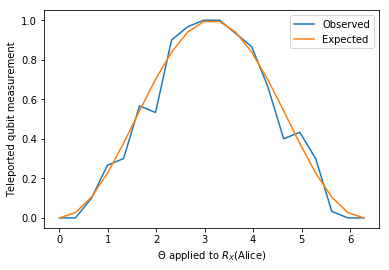

In [6]:
# Set up the quantum vm
qvm = api.SyncConnection() 

# Run the demos
teleportationDemo(qvm)

teleportationRotationDemo(qvm)

In [42]:
# Set up the quantum vm
qvm = api.SyncConnection() 

# Run the demos
teleportationDemo(qvm)

Teleporting |0> from Alice to Bob: 

 [[0]]
Teleporting |1> from Alice to Bob:  [[1]]
Teleporting 1/sqrt(2)*(|0> + |1>) from Alice to Bob: 

 [[0]]




## Transmission via Superdense Coding

In [44]:
fiberOpticAttenuation = -0.16  # dB/km, from Yin, et al, Satellite-based entanglement
cableLength = 1  # km, let's just call it this for now 
# Total attenuation along the fiber, equal to probability of receiving a photon
decibelLoss = cableLength * fiberOpticAttenuation
cableAttenuation = 10 ** (decibelLoss / 10)


def quilAttenuatedSuperdenseTransmission(bit1, bit2):
    alice = 0
    bob = 1

    # Alice prepares a bell pair
    Hilbert = pq.Program(H(alice), CNOT(alice, bob))

    # # Alice sends the first qubit to Bob - if it is attenuated, return 0,0
    # if np.random.rand() > cableAttenuation:
    #     return 0, 0

    # Alice encodes her bits
    if bit2 == 1:
        Hilbert.inst(X(alice))
    if bit1 == 1:
        Hilbert.inst(Z(alice))

    # # Alice sends her qubit to bob and then he decodes the bits
    # if np.random.rand() > cableAttenuation:
    #     return 0, 0

    Hilbert.inst(CNOT(alice, bob),
                 H(alice))

    # Measure the results
    Hilbert.measure(alice, alice)
    Hilbert.measure(bob, bob)

    return Hilbert

def quilAttenuatedIntTransmission(value, qvm):
    '''Transmit an 8-bit unsigned integer value including attenuation effects'''
    bits = np.unpackbits(np.array([value], dtype=np.uint8))
    receivedBits = np.zeros(8, dtype=np.uint8)

    for i in range(4):
        b1, b2 = qvm.run(quilAttenuatedSuperdenseTransmission(bits[2 * i], bits[2 * i + 1]), [0, 1])[0]
        if np.random.rand() > cableAttenuation:
            b1, b2 = 0, 0
        if np.random.rand() > cableAttenuation:
            b1, b2 = 0, 0
        receivedBits[2 * i] = b1
        receivedBits[2 * i + 1] = b2

    return np.packbits(receivedBits)[0]

def quilAttenuatedArrayTransmission(array, qvm):
    receivedArray = np.zeros(array.shape, dtype=np.uint8)
    iterator = np.nditer(array, flags=['multi_index'])

    while not iterator.finished:
        if iterator.iterindex % 100 == 0:
            print "Iteration {}/{}".format(iterator.iterindex, iterator.itersize)
        receivedElement = quilAttenuatedIntTransmission(iterator[0], qvm)
        receivedArray[iterator.multi_index] = receivedElement
        iterator.iternext()
    return receivedArray

Original image:


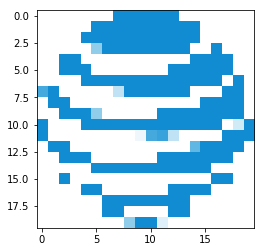

In [46]:
# Let's try transmitting the following image: 
imgData = mp.image.imread("img/attLogo.bmp") 
print "Original image:"
plt.imshow(imgData)

Iteration 0/1600


Iteration 100/1600


Iteration 200/1600


Iteration 300/1600


Iteration 400/1600


Iteration 500/1600


Iteration 600/1600


Iteration 700/1600


Iteration 800/1600


Iteration 900/1600


Iteration 1000/1600


Iteration 1100/1600


Iteration 1200/1600


Iteration 1300/1600


Iteration 1400/1600


Iteration 1500/1600


Reconstructed transmitted image accounting for attenuation effects: (elapsed time: 418.521495104 sec)


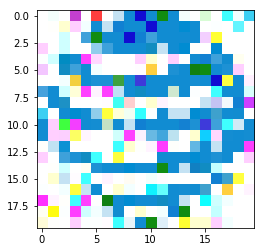

In [47]:
qvm = api.SyncConnection()

# Transmit the image with the attenuated superdense protocol
start = time.time()
receivedArray = quilAttenuatedArrayTransmission(imgData, qvm)
stop = time.time()
print "Reconstructed transmitted image accounting " \
      "for attenuation effects: (elapsed time: {} sec)".format(stop-start)
plt.imshow(receivedArray)

In [52]:
transmissionRate = receivedArray.nbytes / (stop - start)
print "Transmission rate: {}B/s".format(transmissionRate)

Transmission rate: 3.82298165977B/s
